# DT8122 - Assignment

<span style="color:red">Deadline: 2023 August 15 AoE (Anywhere on Earth)</span>

Send a zip file with the notebook both as a .ipynb and as a .pdf file to <a href="mailto:dt8122@idi.ntnu.no">dt8122@idi.ntnu.no</a>. Label the file with your full name.

The task is to implement conditional DDPM for MNIST images. Your implementation should take as input a digit and be able to generate 28x28 grayscale handwritten image of said digit. 

You can add additional cells anywhere in the notebook to make your code more readable.

DDPM: https://arxiv.org/abs/2006.11239

Classifier-free conditional DDPM: https://arxiv.org/abs/2207.12598

The notebook should be run when it is turned in so all plots are visible. All code should be contained in the notebook.


### Install necessary libraries
Any additional libraries you make use of should be installed in this cell.

### Import libraries
All import statements should be contained here.

In [1]:
import random
import math

import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

from typing import Optional, Tuple, TypeVar
import numpy as np
from tqdm import tqdm

### Define constants here
Constants such as number of epochs, device, and learning rate and other hyperparameters should be defined here.

In [42]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 64
##number of steps for defusion and denoising
N = 500
BMIN = 0.0001
BMAX = 0.02
guidence_w = 0.5
device = "cuda:0"


### Functionality for loading and visualizing dataset
We have provided some functionality for loading and visualizing the dataset. You may add more cells/functions here.

In [3]:
## from 0-1 to -1-1
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [15]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()
    
## we gnerate the 10*n_sample conditioned images, so we resize it to the same size in the plt
def show_images_custom(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 8))
    rows = 11
    cols = math.ceil(len(images) / rows)
    for c in range(cols):
        for r in range(rows):
            idx = c * rows + r
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

tensor([8, 3, 8, 4, 6, 8, 1, 4, 2, 3, 7, 1, 5, 8, 8, 9, 0, 7, 1, 2, 8, 4, 5, 4,
        3, 9, 2, 0, 1, 2, 4, 6, 6, 5, 7, 6, 2, 4, 2, 1, 8, 0, 2, 7, 4, 6, 2, 3,
        0, 7, 7, 7, 3, 3, 4, 1, 6, 8, 3, 7, 2, 6, 2, 6])
torch.Size([64, 1, 28, 28])


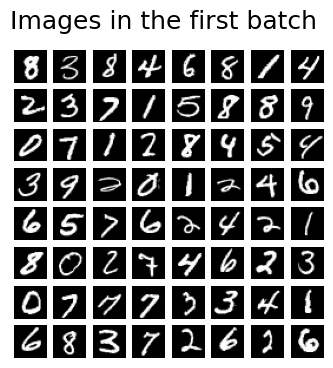

In [13]:
def show_first_batch(loader):
    for batch_feats,batch_labels in loader:
        print(batch_labels)
        print(batch_feats.shape)
        show_images(batch_feats, "Images in the first batch")
        break
show_first_batch(loader)

### Your conditional DDPM implementation should go here
This includes functionality for adding noise to the image.

In [6]:
class Forward_pass:
    def __init__(self) -> None:
        #number of steps
        self.N = N
        self.beta_min = BMIN
        self.beta_max = BMAX
        self._betas, self._alphas, self._alpha_bars = (0, 0 ,0)
        self.get_coefs()
    
    ##linear steps     
    def get_coefs(self):
        """Get the coefficients for the noise schedule.
        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]: 
                betas, alphas, alpha_bars
        """        
        self._betas = torch.linspace(self.beta_min, self.beta_max, self.N)
        self._alphas = 1 - self._betas
        self._alpha_bars = torch.cumprod(self._alphas, dim=0)

    #return the coef for initializing the denoising model
    def ret_coefs(self) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:

        return (self._betas,self._alphas,self._alpha_bars) 
   
    def _q_mean(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> torch.FloatTensor:
        # mean of the distribution q(z_t | z_0)
        sqrt_alpha_bars = torch.sqrt(self._alpha_bars[t.tolist()])
        return sqrt_alpha_bars.view(-1,1,1,1) * z

    def _q_std(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> torch.FloatTensor:
        # std of the distribution q(z_t | z_0)
        std = torch.sqrt(1.0 - self._alpha_bars[t.tolist()])
        return std.view(-1,1,1,1)

    def q_sample(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        # Sample from q(z_t | z_0)

        mean = self._q_mean(z, t)
        std = self._q_std(z, t)
        epsilon = torch.randn_like(z)
        z_t = epsilon * std + mean

        return z_t, epsilon
    
    ##for training, sample random n timesteps for each input, return the repeated features, times-steps sampled and the episilons
    def q_sample_random(
        self,
        z: torch.FloatTensor,
        lables: torch.FloatTensor,
        n_timesteps = 5,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,   torch.IntTensor, torch.IntTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = list(torch.randint(0, self.N-1, (n_timesteps,)))
        print(times)
        times_list = [torch.Tensor([i]).repeat(z.shape[0]).to(torch.int64) for i in times ]
        times_repeated = torch.cat(times_list)
        lables_repeated = lables.repeat(n_timesteps)
        z_repeated = z.repeat(n_timesteps,1,1,1) #shape=(batch_size*5, 1, 28, 28)
        mean = self._q_mean(z_repeated, times_repeated)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z_repeated, times_repeated)
        epsilon = torch.randn_like(z_repeated)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times_repeated, lables_repeated
    
    
    ##for training, sample randomly one timestep for each img, return the repeated features, times-steps sampled and the episilons
    def q_sample_random2(
        self,
        z: torch.FloatTensor,
        lables: torch.FloatTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,  torch.IntTensor, torch.IntTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = torch.randint(0, self.N-1, (z.shape[0],))
        mean = self._q_mean(z, times)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z, times)
        epsilon = torch.randn_like(z)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times, lables

### The implementation of the neural network used to estimate the noise should go here
The network should make use of both time and context embedding.

Any functions/methods used for time and context embeddings should also go here.

In [18]:
## I tried some simpler models but they don't seeem to work well, so finally I use the same Unet implementation as the hin (copied from https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py)
## The difference is we use simple embedding that has only one linear layer and adds to the input image features only
class ResidualConvBlock(torch.nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.GELU(),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class UnetDown(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), torch.nn.MaxPool2d(2)]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            torch.nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(torch.nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            torch.nn.Linear(input_dim, emb_dim),
            torch.nn.GELU(),
            torch.nn.Linear(emb_dim, emb_dim),
        ]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)
          
class ConditionedBackbone(torch.nn.Module):
    def __init__(self, in_channels = 1, hidden_channels = 128, image_size = 28, n_classes=11, num_timesteps=N) -> None:
        super(ConditionedBackbone, self).__init__()

        self.in_channels = in_channels
        self.n_feat = hidden_channels
        self.image_size = image_size
        self.num_timesteps = num_timesteps
        self.n_classes = n_classes  #the classes are 0-9 plus a "empty/unconditional" lable, they are encoded firstly into one hot 

        ## trainable embeddings for lable and time, not working if using a simple linear transformation, so the original model instead
        #self.time_emb = torch.nn.Linear(1, self.image_size*self.image_size)
        #self.lable_emb = torch.nn.Linear(self.n_classes, self.image_size*self.image_size)
        
        self.time_emb = EmbedFC(1, self.image_size*self.image_size)
        self.lable_emb = EmbedFC(self.n_classes, self.image_size*self.image_size)

        self.init_conv = ResidualConvBlock(in_channels, self.n_feat, is_res=True)
        self.down1 = UnetDown(self.n_feat, self.n_feat)
        self.down2 = UnetDown(self.n_feat, 2 * self.n_feat)

        self.to_vec = torch.nn.Sequential(torch.nn.AvgPool2d(7), torch.nn.GELU())
        
        self.up0 = torch.nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            torch.nn.ConvTranspose2d(2 * self.n_feat, 2 * self.n_feat, 7, 7), # otherwise just have 2*n_feat
            torch.nn.GroupNorm(8, 2 * self.n_feat),
            torch.nn.ReLU(),
        )

        self.up1 = UnetUp(4 * self.n_feat, self.n_feat)
        self.up2 = UnetUp(2 * self.n_feat, self.n_feat)
        self.out = torch.nn.Sequential(
            torch.nn.Conv2d(2 * self.n_feat, self.n_feat, 3, 1, 1),
            torch.nn.GroupNorm(8, self.n_feat),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.n_feat, self.in_channels, 3, 1, 1),
        )

        
    def forward(self, x, lables, t) -> float:
        # x is (noisy) image batch (from the Forward_pass for training and from the N(0,1) for sampling),  (batch_size, channel(1), 28, 28)
        # diff_noise are the corresponding noise in the forward pass, 
        #labels are the numbers from 0-10, 10 represents the unconditioned sample, t is the timestep usually from 0-999, 

        
        time_emb = self.time_emb(t.type(torch.float32).view(-1,1)).view(-1, 1, self.image_size, self.image_size)
        
        lable_one_hot = torch.nn.functional.one_hot(lables, num_classes=self.n_classes).type(torch.float)
        lable_emb  = self.lable_emb(lable_one_hot).view(-1, 1, self.image_size, self.image_size)
        #two embeddings are added and multiplied to the input, representing different factors
        
        x = self.init_conv(lable_emb * x + time_emb)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
    

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(up1, down2)  # add and multiply embeddings
        up3 = self.up2(up2, down1)
        e_pred = self.out(torch.cat((up3, x), 1))

        return e_pred
    
class Reverse_pass(torch.nn.Module):
    def __init__(self, model, alphas, alpha_bars, betas, num_classes = 11 ) -> None:
        super().__init__()
        self.model = model.to(device)
        self.N = N
        self.num_classes = num_classes
        ##for computing the samples
        self.alphas = alphas
        self.sqrt_1_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        ##we use the simpler version of sigma for the reverse pass
        self.sigmas = torch.sqrt(betas) 
        
        #loss
        self.mse = torch.nn.MSELoss()
        
    def sample(self, n_samples = 3, image_size = 28, guidence_w = guidence_w): 
        ## sample "n" samples for each number “0-9” (including the unditional label "10") using 'Classifier-Free Diffusion Guidance'
        with torch.no_grad():
            #sample noised images and arrange labels
            batch_size = n_samples*self.num_classes
            #x_batch = torch.randn(batch_size, 1, image_size, image_size).to(device)
            x_batch = torch.randn(batch_size, 1, image_size, image_size).to(device)
            ##labels = [0,0,0,1,1,1,2,2,2....]  
            labels = [ torch.tensor([i], device=device).repeat(n_samples) for i in range(self.num_classes)]
            #labels = torch.cat(labels).to(device)
            labels = torch.cat(labels)
            # unconditioned labels for interpolation (label = 10)
            labels_uncon = torch.full_like(labels, self.num_classes-1)
            labels = torch.cat((labels, labels_uncon))
            last_batch = x_batch
            for i in range(self.N, 0, -1):
                print(f'sampling timestep {i}\n')
                #current_t = torch.tensor([i]).to(device)
                current_t = torch.tensor([i-1],device=device)  #i-1 for one-hot encoding
                t_batch = current_t.repeat(batch_size) #(batch_size)

                # duplicate the current img for unconditioned sampling
                x_doubled = last_batch.repeat(2,1,1,1) #(2*batch_size, channel, img_size, img_size)
                t_doubled = t_batch.repeat(2) #(2*batch_size)

                # predict the diffusion noise, and interpolate
                diff_noise = self.model(x_doubled, labels, t_doubled)
                diff_con = diff_noise[:batch_size]
                diff_uncon = diff_noise[batch_size:]
                diff_noise_final = (1+guidence_w)*diff_con - guidence_w*diff_uncon
                # predict x_t-1
                #observation_noise = torch.randn(batch_size, 1, image_size, image_size).to(device) if i > 1 else 0
                observation_noise = torch.randn(batch_size, 1, image_size, image_size).to(device) if i > 1 else 0
                x_predict = (1/torch.sqrt(self.alphas[i-1])) * (last_batch - diff_noise_final * (1 - self.alphas[i-1]) / self.sqrt_1_minus_alpha_bars[i-1]) + self.sigmas[i-1] * observation_noise
                
                last_batch = x_predict
            return last_batch
    
    def compute_loss(self, batch_input, batch_noise, batch_time, batch_lables):
        #a batch of diffused input (by the forward process), with its difuusion noise,  timesteps and labels as input
        # return the loss of this batch for training the model
        
        predicted_noise = self.model(batch_input.to(device), batch_lables.to(device), batch_time.to(device))
        return self.mse(batch_noise.to(device), predicted_noise)

### Show that you can generate images before the model is trained
This should demonstrate that the backwards pass works. The generated images are expected to be noise.

sampling timestep 500

sampling timestep 499

sampling timestep 498

sampling timestep 497

sampling timestep 496

sampling timestep 495

sampling timestep 494

sampling timestep 493

sampling timestep 492

sampling timestep 491

sampling timestep 490

sampling timestep 489

sampling timestep 488

sampling timestep 487

sampling timestep 486

sampling timestep 485

sampling timestep 484

sampling timestep 483

sampling timestep 482

sampling timestep 481

sampling timestep 480

sampling timestep 479

sampling timestep 478

sampling timestep 477

sampling timestep 476

sampling timestep 475

sampling timestep 474

sampling timestep 473

sampling timestep 472

sampling timestep 471

sampling timestep 470

sampling timestep 469

sampling timestep 468

sampling timestep 467

sampling timestep 466

sampling timestep 465

sampling timestep 464

sampling timestep 463

sampling timestep 462

sampling timestep 461

sampling timestep 460

sampling timestep 459

sampling timestep 458

sampling ti

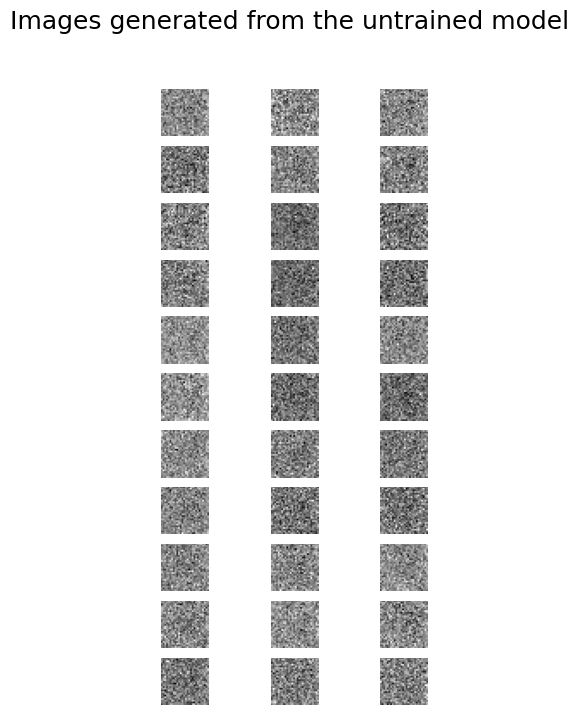

In [38]:
model = ConditionedBackbone()
forward = Forward_pass()
betas,alphas,alpha_bars = forward.ret_coefs()
reverse = Reverse_pass(model, alphas, alpha_bars, betas)
return_batch = reverse.sample()
show_images_custom(return_batch, "Images generated from the untrained model")


### Implement training loop
Train the model here. There should be some indication of how long the model took to train, both total and per epoch. For good results you will want to train the model for several epochs, but with a good implementation you should expect to see something that looks like digits after only a single epoch.

In [23]:
def train_conditionedDDPM(n_epochs = 10, learning_rate = 1e-4):
    print(f"{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters to train")
    optimizer = torch.optim.Adam(reverse.parameters(), lr=learning_rate)
    for i in range(n_epochs):
        print(f"Training epoch: {i+1}")
        progress_loader = tqdm(loader)
        total_loss = 0
        for batch_feats,batch_labels in progress_loader:
            optimizer.zero_grad()
            #sample with forward pass
            #z_out, epsilon_target, times, labels= forward.q_sample_random(batch_feats, batch_labels)
            z_out, epsilon_target, times, labels= forward.q_sample_random2(batch_feats, batch_labels)
            loss = reverse.compute_loss(z_out, epsilon_target, times, labels)
            total_loss += loss
            loss.backward()
            optimizer.step()
            
        print(f'Loss for the current epoch is {total_loss}')
            

### Train and visualize the model
We want to see several generated examples of each digit.

In [43]:
model = ConditionedBackbone()
forward = Forward_pass()
betas,alphas,alpha_bars = forward.ret_coefs()
reverse = Reverse_pass(model, alphas, alpha_bars, betas)
train_conditionedDDPM()

7657857 parameters to train
Training epoch: 1


100%|██████████| 938/938 [00:28<00:00, 32.70it/s]


Loss for the current epoch is 590.5718383789062
Training epoch: 2


100%|██████████| 938/938 [00:29<00:00, 31.87it/s]


Loss for the current epoch is 81.71276092529297
Training epoch: 3


100%|██████████| 938/938 [00:31<00:00, 29.98it/s]


Loss for the current epoch is 66.81886291503906
Training epoch: 4


100%|██████████| 938/938 [00:32<00:00, 29.06it/s]


Loss for the current epoch is 60.47119140625
Training epoch: 5


100%|██████████| 938/938 [00:31<00:00, 29.53it/s]


Loss for the current epoch is 56.47073745727539
Training epoch: 6


100%|██████████| 938/938 [00:30<00:00, 30.64it/s]


Loss for the current epoch is 54.28052520751953
Training epoch: 7


100%|██████████| 938/938 [00:29<00:00, 31.61it/s]


Loss for the current epoch is 51.96539306640625
Training epoch: 8


100%|██████████| 938/938 [00:29<00:00, 31.90it/s]


Loss for the current epoch is 49.88612747192383
Training epoch: 9


100%|██████████| 938/938 [00:29<00:00, 31.98it/s]


Loss for the current epoch is 48.270503997802734
Training epoch: 10


100%|██████████| 938/938 [00:29<00:00, 32.03it/s]

Loss for the current epoch is 47.755882263183594


sampling timestep 500

sampling timestep 499

sampling timestep 498

sampling timestep 497

sampling timestep 496

sampling timestep 495

sampling timestep 494

sampling timestep 493

sampling timestep 492

sampling timestep 491

sampling timestep 490

sampling timestep 489

sampling timestep 488

sampling timestep 487

sampling timestep 486

sampling timestep 485

sampling timestep 484

sampling timestep 483

sampling timestep 482

sampling timestep 481

sampling timestep 480

sampling timestep 479

sampling timestep 478

sampling timestep 477

sampling timestep 476

sampling timestep 475

sampling timestep 474

sampling timestep 473

sampling timestep 472

sampling timestep 471

sampling timestep 470

sampling timestep 469

sampling timestep 468

sampling timestep 467

sampling timestep 466

sampling timestep 465

sampling timestep 464

sampling timestep 463

sampling timestep 462

sampling timestep 461

sampling timestep 460

sampling timestep 459

sampling timestep 458

sampling ti

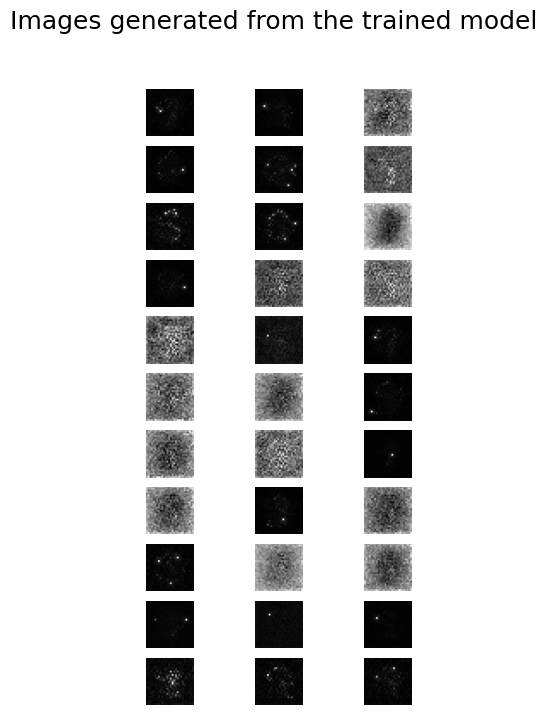

In [48]:
return_batch = reverse.sample(guidence_w = 0.5)
show_images_custom(return_batch, "Images generated from the trained model")